<a href="https://colab.research.google.com/github/vladimirzotk1n/Credit-Scoring-Project/blob/main/Credit_Score_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1.Import Data and Required Packages

In [121]:
import os
import sklearn
import re


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats as st


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_curve, ConfusionMatrixDisplay, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

%matplotlib inline
warnings.filterwarnings('ignore')

## 2.Data Understanding

In [122]:
trainpath = "/content/sample_data/train.csv"
testpath = "/content/sample_data/test.csv"

df = pd.read_csv(trainpath)
test_df = pd.read_csv(testpath)

In [123]:
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [124]:
df.shape

(100000, 28)

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

In [126]:
df.describe()

,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Delay_from_due_date,Num_Credit_Inquiries,Credit_Utilization_Ratio,Total_EMI_per_month
count,84998.000000,100000.000000,100000.00000,100000.000000,100000.000000,98035.000000,100000.000000,100000.000000
mean,4194.170850,17.091280,22.47443,72.466040,21.068780,27.754251,32.285173,1403.118217
std,3183.686167,117.404834,129.05741,466.422621,14.860104,193.177339,5.116875,8306.041270
min,303.645417,-1.000000,0.00000,1.000000,-5.000000,0.000000,20.000000,0.000000
25%,1625.568229,3.000000,4.00000,8.000000,10.000000,3.000000,28.052567,30.306660
50%,3093.745000,6.000000,5.00000,13.000000,18.000000,6.000000,32.305784,69.249473
75%,5957.448333,7.000000,7.00000,20.000000,28.000000,9.000000,36.496663,161.224249
max,15204.633333,1798.000000,1499.00000,5797.000000,67.000000,2597.000000,50.000000,82331.000000


Change type to category

In [127]:
cat_cols = ['Month', 'Occupation', 'Type_of_Loan', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour', 'Credit_Score']
df[cat_cols] = df[cat_cols].astype('category')

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   ID                        100000 non-null  object  
 1   Customer_ID               100000 non-null  object  
 2   Month                     100000 non-null  category
 3   Name                      90015 non-null   object  
 4   Age                       100000 non-null  object  
 5   SSN                       100000 non-null  object  
 6   Occupation                100000 non-null  category
 7   Annual_Income             100000 non-null  object  
 8   Monthly_Inhand_Salary     84998 non-null   float64 
 9   Num_Bank_Accounts         100000 non-null  int64   
 10  Num_Credit_Card           100000 non-null  int64   
 11  Interest_Rate             100000 non-null  int64   
 12  Num_of_Loan               100000 non-null  object  
 13  Type_of_Loan              8859

## 3.Data Cleaning

- There are few columns that should be numerical but represented as object. **'Age','Annual_Income','Num_of_Loan','Num_of_Delayed_Payment','Changed_Credit_Limit', 'Outstanding_Debt'** etc
- For categorical values we will replace null and wrong information with mode per customer
- For numerical values we will replace null and wrong information with forward/backward or mean
- Drop redundant columns 'ID', 'Name', 'SSN', 'Type_of_Loan', 'Occupation', 'Customer_ID'
- Replace wrong info ("!@9#%8", "_", "__") with Null

### Check null

In [129]:
nan_percent = round(df.isna().sum()/df.shape[0]*100 , 4)
nan_percent

,0
ID,0.000
Customer_ID,0.000
Month,0.000
Name,9.985
Age,0.000
SSN,0.000
Occupation,0.000
Annual_Income,0.000
Monthly_Inhand_Salary,15.002
Num_Bank_Accounts,0.000


In [130]:
nan_percent[nan_percent > 0]

,0
Name,9.985
Monthly_Inhand_Salary,15.002
Type_of_Loan,11.408
Num_of_Delayed_Payment,7.002
Num_Credit_Inquiries,1.965
Credit_History_Age,9.030
Amount_invested_monthly,4.479
Monthly_Balance,1.200


In [131]:
print(f'It is {df.duplicated().sum()} rows that are duplicated')

It is 0 rows that are duplicated


In [132]:
print(f'It is {df.nunique()} unique values')

It is ID                          100000
Customer_ID                  12500
Month                            8
Name                         10139
Age                           1788
SSN                          12501
Occupation                      16
Annual_Income                18940
Monthly_Inhand_Salary        13235
Num_Bank_Accounts              943
Num_Credit_Card               1179
Interest_Rate                 1750
Num_of_Loan                    434
Type_of_Loan                  6260
Delay_from_due_date             73
Num_of_Delayed_Payment         749
Changed_Credit_Limit          4384
Num_Credit_Inquiries          1223
Credit_Mix                       4
Outstanding_Debt             13178
Credit_Utilization_Ratio    100000
Credit_History_Age             404
Payment_of_Min_Amount            3
Total_EMI_per_month          14950
Amount_invested_monthly      91049
Payment_Behaviour                7
Monthly_Balance              98792
Credit_Score                     3
dtype: int64 u

### Drop redundant columns

In [133]:
df.drop(['ID', 'Name', 'SSN', 'Type_of_Loan'], axis=1, inplace=True)

### Handle Categorical variables

In [134]:
categorical = list(df.select_dtypes('category').columns)

In [135]:
for c in categorical:
  print(c)
  print(df[c].value_counts())
  print()

Month
Month
April       12500
August      12500
February    12500
January     12500
July        12500
June        12500
March       12500
May         12500
Name: count, dtype: int64

Occupation
Occupation
_______          7062
Lawyer           6575
Architect        6355
Engineer         6350
Scientist        6299
Mechanic         6291
Accountant       6271
Developer        6235
Media_Manager    6232
Teacher          6215
Entrepreneur     6174
Doctor           6087
Journalist       6085
Manager          5973
Musician         5911
Writer           5885
Name: count, dtype: int64

Credit_Mix
Credit_Mix
Standard    36479
Good        24337
_           20195
Bad         18989
Name: count, dtype: int64

Payment_of_Min_Amount
Payment_of_Min_Amount
Yes    52326
No     35667
NM     12007
Name: count, dtype: int64

Payment_Behaviour
Payment_Behaviour
Low_spent_Small_value_payments      25513
High_spent_Medium_value_payments    17540
Low_spent_Medium_value_payments     13861
High_spent_Large_value_

For `Credit_Mix` replace `_` with NaN

`Payment_Behaviour` replace `!@9#%8` with Nan

In [136]:
df['Payment_Behaviour'] = df['Payment_Behaviour'].apply(lambda x: np.NaN if x == "!@9#%8" else x)
df['Credit_Mix'] = df['Credit_Mix'].apply(lambda x: np.NaN if x == "_" else x)



### Handle Numerical variables

In [137]:
cols=['Age','Annual_Income','Num_of_Loan','Num_of_Delayed_Payment','Changed_Credit_Limit', 'Outstanding_Debt']
for col in cols:
  df[col] = df[col].apply(lambda x: x if x is np.nan or not isinstance(x, str)
                      else x.replace("_","")).replace("",np.nan)
  df[col] = df[col].astype('float')

In [138]:
nan_percent = round(df.isna().sum()/df.shape[0]*100 , 4)
nan_percent[nan_percent > 0]

,0
Monthly_Inhand_Salary,15.002
Num_of_Delayed_Payment,7.002
Changed_Credit_Limit,2.091
Num_Credit_Inquiries,1.965
Credit_Mix,20.195
Credit_History_Age,9.030
Amount_invested_monthly,4.479
Payment_Behaviour,7.600
Monthly_Balance,1.200


#### `Monthly_Inhand_Salary` column

In [139]:
df['Monthly_Inhand_Salary'] = df.groupby('Customer_ID')['Monthly_Inhand_Salary'].transform(lambda v: v.mean())
df['Monthly_Inhand_Salary'] = df['Monthly_Inhand_Salary'].astype('float')

#### `Num_of_Delayed_Payment` column

In [140]:
df['Num_of_Delayed_Payment'] = df.groupby('Customer_ID')['Num_of_Delayed_Payment'].transform(lambda v: v.ffill())
df['Num_of_Delayed_Payment'] = df.groupby('Customer_ID')['Num_of_Delayed_Payment'].transform(lambda v: v.bfill())

#### `Amount_invested_monthly` column


In [141]:
def return_null(val):
  if isinstance(val, str) and "__" in val:
    return np.NaN
  else:
    return val

In [142]:
df['Amount_invested_monthly'] = df['Amount_invested_monthly'].apply(return_null)
df['Amount_invested_monthly'] = df['Amount_invested_monthly'].astype('float')

In [143]:
df['Amount_invested_monthly'] = df.groupby('Customer_ID')['Amount_invested_monthly'].transform(lambda v: v.mean())

#### `Num_Credit_Inquiries` column

In [144]:
df['Num_Credit_Inquiries'].quantile([0.10, 0.85, 0.98, 0.985, 0.99])

,Num_Credit_Inquiries
0.100,1.00
0.850,11.00
0.980,16.00
0.985,298.49
0.990,1109.28


In [145]:
df['Num_Credit_Inquiries'] = df.groupby('Customer_ID')['Num_Credit_Inquiries'].transform(lambda v: v.median())
df['Num_Credit_Inquiries'] = df['Num_Credit_Inquiries'].astype('float')

#### `Monthly_Balance` column

In [146]:
df['Monthly_Balance'] = df['Monthly_Balance'].apply(return_null)
df['Monthly_Balance'] = df['Monthly_Balance'].astype('float')

In [147]:
df['Monthly_Balance'] = df.groupby('Customer_ID')['Monthly_Balance'].transform(lambda v: v.mean())

`Payment_Behaviour, Credit_Mix and Changed_Credit_Limit` column

In [148]:
df['Payment_Behaviour'] = df.groupby('Customer_ID')['Payment_Behaviour'].apply(lambda x: x.fillna(x.mode()[0])).reset_index(drop=True)
df['Credit_Mix'] = df.groupby('Customer_ID')['Credit_Mix'].apply(lambda x: x.fillna(x.mode()[0])).reset_index(drop=True)

In [149]:
df['Changed_Credit_Limit'] = df.groupby('Customer_ID')['Changed_Credit_Limit'].transform(lambda v: v.mode()[0])

#### `Credit_History_Age` column

In [150]:
def get_age(val):
  try:
    year, month = 0, 0
    if re.search('year', val, re.IGNORECASE):
      year = int(re.findall('\d+', val)[0])
    if re.search('month', val, re.IGNORECASE):
      month = int(re.findall('\d+', val)[1])
    return year*12+month
  except:
    return np.NaN

In [151]:
df['Credit_History_Age'] = df['Credit_History_Age'].apply(get_age)

In [152]:
df['Credit_History_Age'] = df.groupby('Customer_ID')['Credit_History_Age'].transform(lambda v: v.ffill())
df['Credit_History_Age'] = df.groupby('Customer_ID')['Credit_History_Age'].transform(lambda v: v.bfill())
df['Credit_History_Age'] = df['Credit_History_Age'].astype('float')

#### `Age` column

As we can see there are some negative values as well as values greater than 100. Let's handle those values

In [153]:
df.select_dtypes('object').head(3)

,Customer_ID,Credit_Mix,Payment_Behaviour
0,CUS_0xd40,Bad,Low_spent_Large_value_payments
1,CUS_0xd40,Bad,High_spent_Small_value_payments
2,CUS_0xd40,Bad,High_spent_Medium_value_payments


In [154]:
def clean_age(x):
  if x > 100 or x <=0:
    return np.NaN
  return x

In [155]:
df['Age'] = df['Age'].apply(lambda x: x if x is np.nan or not isinstance(x, str)
                    else x.replace("_","")).replace("",np.nan)
df['Age'] = df['Age'].astype('float')

In [156]:
df['Age'] = df['Age'].apply(clean_age)
df['Age'] = df.groupby('Customer_ID')['Age'].transform(lambda v: v.mode()[0])

In [157]:
nan_percent = round(df.isna().sum()/df.shape[0]*100 , 4)
nan_percent[nan_percent > 0]

,0


In [158]:
cat_cols = ['Credit_Mix', 'Payment_Behaviour']
df[cat_cols] = df[cat_cols].astype('category')

In [159]:
df.shape

(100000, 24)

## 4 Sanity checks

In [160]:
df.describe()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance
count,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,33.274560,1.764157e+05,4198.468568,17.091280,22.47443,72.466040,3.009960,21.068780,30.690700,10.393543,5.794600,1426.220376,32.285173,221.136220,1403.118217,195.751837,403.120320
std,10.764438,1.429618e+06,3187.031426,117.404834,129.05741,466.422621,62.647879,14.860104,224.881705,6.512529,3.831618,1155.129026,5.116875,99.680454,8306.041270,136.842331,175.470745
min,14.000000,7.005930e+03,303.645417,-1.000000,0.00000,1.000000,-100.000000,-5.000000,-3.000000,-5.010000,0.000000,0.230000,20.000000,1.000000,0.000000,14.528879,92.841401
25%,24.000000,1.945750e+04,1625.744479,3.000000,4.00000,8.000000,1.000000,10.000000,9.000000,5.500000,3.000000,566.072500,28.052567,144.000000,30.306660,97.690749,284.546710
50%,33.000000,3.757861e+04,3097.016667,6.000000,5.00000,13.000000,3.000000,18.000000,14.000000,9.340000,5.000000,1166.155000,32.305784,219.000000,69.249473,152.081485,338.491580
75%,42.000000,7.279092e+04,5961.664375,7.000000,7.00000,20.000000,5.000000,28.000000,18.000000,14.672500,8.500000,1945.962500,36.496663,302.000000,161.224249,257.566585,465.372970
max,56.000000,2.419806e+07,15204.633333,1798.000000,1499.00000,5797.000000,1496.000000,67.000000,4397.000000,29.980000,17.000000,4998.070000,50.000000,404.000000,82331.000000,1005.847285,1349.264887


### `Num_Bank_Accounts`

In [161]:
df['Num_Bank_Accounts'].describe()

,Num_Bank_Accounts
count,100000.000000
mean,17.091280
std,117.404834
min,-1.000000
25%,3.000000
50%,6.000000
75%,7.000000
max,1798.000000


Num_Bank_Accounts can not be negative

In [162]:
df['Num_Bank_Accounts'].replace(-1, 0, inplace=True)

In [163]:
df['Num_Bank_Accounts'].value_counts(ascending=False).head(15)

,count
Num_Bank_Accounts,
6,13001
7,12823
8,12765
4,12186
5,12118
3,11950
9,5443
10,5247
1,4490


We can see that Num_Bank_Accounts are in range of 0 to 1798. Account number greatert than 11 is clearly wrong entry.
Replace those entries with mode as per each customer

In [164]:
df['Num_Bank_Accounts'] = df['Num_Bank_Accounts'].apply(lambda x: np.NaN if x>10 else x)
df['Num_Bank_Accounts'] = df.groupby('Customer_ID')['Num_Bank_Accounts'].transform(lambda v: v.mode()[0])

### `Num_Credit_Card`

In [165]:
df['Num_Credit_Card'].describe()

,Num_Credit_Card
count,100000.00000
mean,22.47443
std,129.05741
min,0.00000
25%,4.00000
50%,5.00000
75%,7.00000
max,1499.00000


In [166]:
df['Num_Credit_Card'].value_counts(ascending=False).head(15)

,count
Num_Credit_Card,
5,18459
7,16615
6,16559
4,14030
3,13277
8,4956
10,4860
9,4643
2,2149


In [167]:
df['Num_Credit_Card'] = df['Num_Credit_Card'].apply(lambda x: np.NaN if x>10 else x)
df['Num_Credit_Card'] = df.groupby('Customer_ID')['Num_Credit_Card'].transform(lambda v: v.mode()[0])

### `Interest_Rate`

In [168]:
df['Interest_Rate'].describe()

,Interest_Rate
count,100000.000000
mean,72.466040
std,466.422621
min,1.000000
25%,8.000000
50%,13.000000
75%,20.000000
max,5797.000000


Normal interest rate is in between 5-30%. We will impute wring entries

In [169]:
df['Interest_Rate'] = df['Interest_Rate'].apply(lambda x: np.NaN if x>30 else x)
df['Interest_Rate'].replace(np.NaN, 0, inplace=True)

In [170]:
mode_emi = df.groupby('Customer_ID')['Interest_Rate'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)
df.drop("Interest_Rate",axis=1,inplace=True)
df = pd.merge(left=df,right=mode_emi,how="left",left_on="Customer_ID",right_index=True)

### `Num_of_Loan`

In [171]:
df['Num_of_Loan'].value_counts(ascending=False).head(15)

,count
Num_of_Loan,
3.0,15104
2.0,15032
4.0,14743
0.0,10930
1.0,10606
6.0,7803
7.0,7344
5.0,7197
-100.0,3876


Number_of_loan can not be negative

In [172]:
df['Num_of_Loan'] = df['Num_of_Loan'].apply(lambda x: np.NaN if (x>10 or x<0) else x)
df['Num_of_Loan'] = df.groupby('Customer_ID')['Num_of_Loan'].transform(lambda v: v.mode()[0])

### `Num_of_Delayed_Payment`

Num_of_Delayed_Payment can not be greater than 30

In [173]:
df['Num_of_Delayed_Payment'].describe()

,Num_of_Delayed_Payment
count,100000.000000
mean,30.690700
std,224.881705
min,-3.000000
25%,9.000000
50%,14.000000
75%,18.000000
max,4397.000000


In [174]:
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].apply(lambda x: np.NaN if (x>30 or x<0) else x)
df['Num_of_Delayed_Payment'] = df.groupby('Customer_ID')['Num_of_Delayed_Payment'].transform(lambda v: v.mode()[0])

### `Total_EMI_per_month`

In [175]:
df['Total_EMI_per_month'].describe()

,Total_EMI_per_month
count,100000.000000
mean,1403.118217
std,8306.041270
min,0.000000
25%,30.306660
50%,69.249473
75%,161.224249
max,82331.000000


In [176]:
mode_emi = df.groupby('Customer_ID')['Total_EMI_per_month'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)

df.drop("Total_EMI_per_month",axis=1,inplace=True)
df = pd.merge(left=df,right=mode_emi,how="left",left_on="Customer_ID",right_index=True)

In [177]:
df['Total_EMI_per_month'].describe()

,Total_EMI_per_month
count,100000.000000
mean,105.543371
std,125.810030
min,0.000000
25%,29.049047
50%,66.033915
75%,145.582332
max,1779.103254


### `Delay_from_due_date`

In [178]:
df['Delay_from_due_date'].describe()

,Delay_from_due_date
count,100000.000000
mean,21.068780
std,14.860104
min,-5.000000
25%,10.000000
50%,18.000000
75%,28.000000
max,67.000000


In [179]:
nan_percent = round(df.isna().sum()/df.shape[0]*100 , 4)
nan_percent[nan_percent > 0]

,0


In [180]:
df.shape

(100000, 24)

## 5.EDA

In [181]:
df.drop(['Customer_ID', 'Month', 'Occupation'], axis=1, inplace=True)

In [182]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 21 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   Age                       100000 non-null  float64 
 1   Annual_Income             100000 non-null  float64 
 2   Monthly_Inhand_Salary     100000 non-null  float64 
 3   Num_Bank_Accounts         100000 non-null  float64 
 4   Num_Credit_Card           100000 non-null  float64 
 5   Num_of_Loan               100000 non-null  float64 
 6   Delay_from_due_date       100000 non-null  int64   
 7   Num_of_Delayed_Payment    100000 non-null  float64 
 8   Changed_Credit_Limit      100000 non-null  float64 
 9   Num_Credit_Inquiries      100000 non-null  float64 
 10  Credit_Mix                100000 non-null  category
 11  Outstanding_Debt          100000 non-null  float64 
 12  Credit_Utilization_Ratio  100000 non-null  float64 
 13  Credit_History_Age        1000

In [183]:
df.head()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,...,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Interest_Rate,Total_EMI_per_month
0,23.0,19114.12,1824.843333,3.0,4.0,4.0,3,4.0,11.27,4.0,...,809.98,26.822620,265.0,No,98.35409,Low_spent_Large_value_payments,304.555294,Good,3.0,49.574949
1,23.0,19114.12,1824.843333,3.0,4.0,4.0,-1,4.0,11.27,4.0,...,809.98,31.944960,265.0,No,98.35409,High_spent_Small_value_payments,304.555294,Good,3.0,49.574949
2,23.0,19114.12,1824.843333,3.0,4.0,4.0,3,4.0,11.27,4.0,...,809.98,28.609352,267.0,No,98.35409,High_spent_Medium_value_payments,304.555294,Good,3.0,49.574949
3,23.0,19114.12,1824.843333,3.0,4.0,4.0,5,4.0,11.27,4.0,...,809.98,31.377862,268.0,No,98.35409,High_spent_Medium_value_payments,304.555294,Good,3.0,49.574949
4,23.0,19114.12,1824.843333,3.0,4.0,4.0,6,4.0,11.27,4.0,...,809.98,24.797347,269.0,No,98.35409,Low_spent_Large_value_payments,304.555294,Good,3.0,49.574949


In [184]:
df.describe()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Amount_invested_monthly,Monthly_Balance,Interest_Rate,Total_EMI_per_month
count,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,33.274560,1.764157e+05,4198.468568,5.367840,5.532320,3.532880,21.068780,13.262720,10.393543,5.794600,1426.220376,32.285173,221.136220,195.751837,403.120320,12.489280,105.543371
std,10.764438,1.429618e+06,3187.031426,2.592597,2.066543,2.446356,14.860104,6.200852,6.512529,3.831618,1155.129026,5.116875,99.680454,136.842331,175.470745,8.072728,125.810030
min,14.000000,7.005930e+03,303.645417,0.000000,0.000000,0.000000,-5.000000,0.000000,-5.010000,0.000000,0.230000,20.000000,1.000000,14.528879,92.841401,0.000000,0.000000
25%,24.000000,1.945750e+04,1625.744479,3.000000,4.000000,2.000000,10.000000,9.000000,5.500000,3.000000,566.072500,28.052567,144.000000,97.690749,284.546710,6.000000,29.049047
50%,33.000000,3.757861e+04,3097.016667,5.000000,5.000000,3.000000,18.000000,14.000000,9.340000,5.000000,1166.155000,32.305784,219.000000,152.081485,338.491580,11.000000,66.033915
75%,42.000000,7.279092e+04,5961.664375,7.000000,7.000000,5.000000,28.000000,18.000000,14.672500,8.500000,1945.962500,36.496663,302.000000,257.566585,465.372970,18.000000,145.582332
max,56.000000,2.419806e+07,15204.633333,10.000000,10.000000,9.000000,67.000000,28.000000,29.980000,17.000000,4998.070000,50.000000,404.000000,1005.847285,1349.264887,30.000000,1779.103254


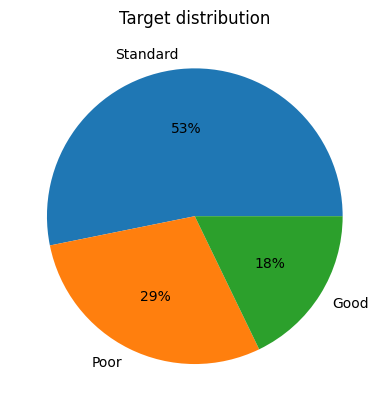

In [186]:
plt.pie(df['Credit_Score'].value_counts(), labels=df['Credit_Score'] .value_counts().index,autopct='%.0f%%')
plt.title('Target distribution')
plt.show()

In [66]:
cols = ['Annual_Income', 'Monthly_Inhand_Salary', 'Delay_from_due_date', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age', 'Amount_invested_monthly', 'Monthly_Balance', 'Interest_Rate', 'Total_EMI_per_month']


In [67]:
['Num_Bank_Accounts',
 'Num_Credit_Card',
 'Num_of_Loan',
 'Num_of_Delayed_Payment']
len(cols)

12

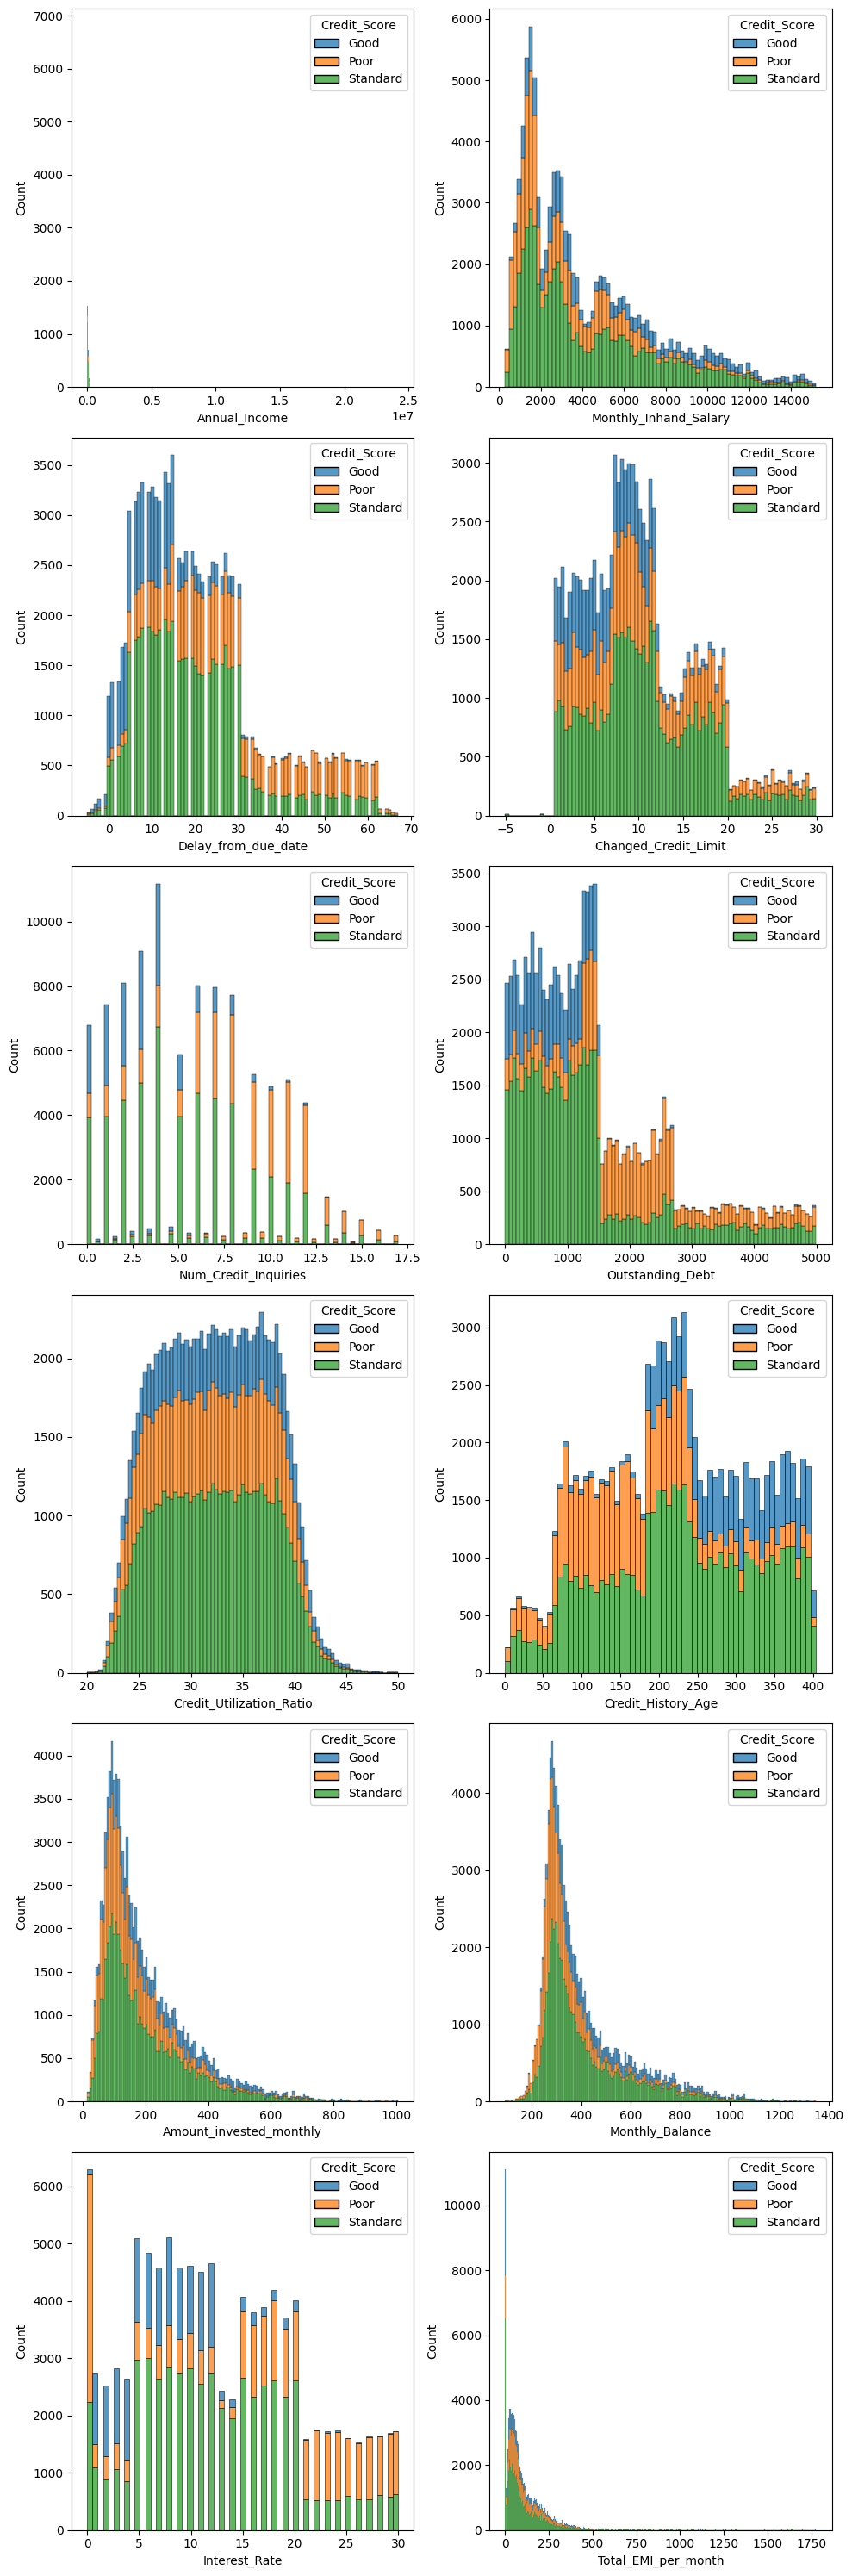

In [68]:
rows=[len(cols)//2 if len(cols)%2==0 else len(cols)//2+1]

fig, axes=plt.subplots(rows[0],2,figsize=(10,30))
ax = axes.flatten()
for i,col in enumerate(cols):
    sns.histplot(data=df, x=col, hue="Credit_Score", ax=ax[i], multiple="stack")

plt.tight_layout()

### Outlier preprocessing

In [69]:
df.shape

(100000, 21)

In [70]:
cat_df = df.select_dtypes('category')
num_df = df.select_dtypes(exclude='category')

In [71]:
cols = list(num_df.columns)

In [72]:
df.describe()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Amount_invested_monthly,Monthly_Balance,Interest_Rate,Total_EMI_per_month
count,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,33.274560,1.764157e+05,4198.468568,5.367840,5.532320,3.532880,21.068780,13.262720,10.393543,5.794600,1426.220376,32.285173,221.136220,195.751837,403.120320,12.489280,105.543371
std,10.764438,1.429618e+06,3187.031426,2.592597,2.066543,2.446356,14.860104,6.200852,6.512529,3.831618,1155.129026,5.116875,99.680454,136.842331,175.470745,8.072728,125.810030
min,14.000000,7.005930e+03,303.645417,0.000000,0.000000,0.000000,-5.000000,0.000000,-5.010000,0.000000,0.230000,20.000000,1.000000,14.528879,92.841401,0.000000,0.000000
25%,24.000000,1.945750e+04,1625.744479,3.000000,4.000000,2.000000,10.000000,9.000000,5.500000,3.000000,566.072500,28.052567,144.000000,97.690749,284.546710,6.000000,29.049047
50%,33.000000,3.757861e+04,3097.016667,5.000000,5.000000,3.000000,18.000000,14.000000,9.340000,5.000000,1166.155000,32.305784,219.000000,152.081485,338.491580,11.000000,66.033915
75%,42.000000,7.279092e+04,5961.664375,7.000000,7.000000,5.000000,28.000000,18.000000,14.672500,8.500000,1945.962500,36.496663,302.000000,257.566585,465.372970,18.000000,145.582332
max,56.000000,2.419806e+07,15204.633333,10.000000,10.000000,9.000000,67.000000,28.000000,29.980000,17.000000,4998.070000,50.000000,404.000000,1005.847285,1349.264887,30.000000,1779.103254


In [73]:
group1 = ['Age', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries']
group2 = ['Credit_Utilization_Ratio', 'Credit_History_Age']
group3 = ['Amount_invested_monthly', 'Monthly_Balance', 'Interest_Rate', 'Total_EMI_per_month']
group4 = ['Monthly_Inhand_Salary', 'Outstanding_Debt']
'Annual_Income'

'Annual_Income'

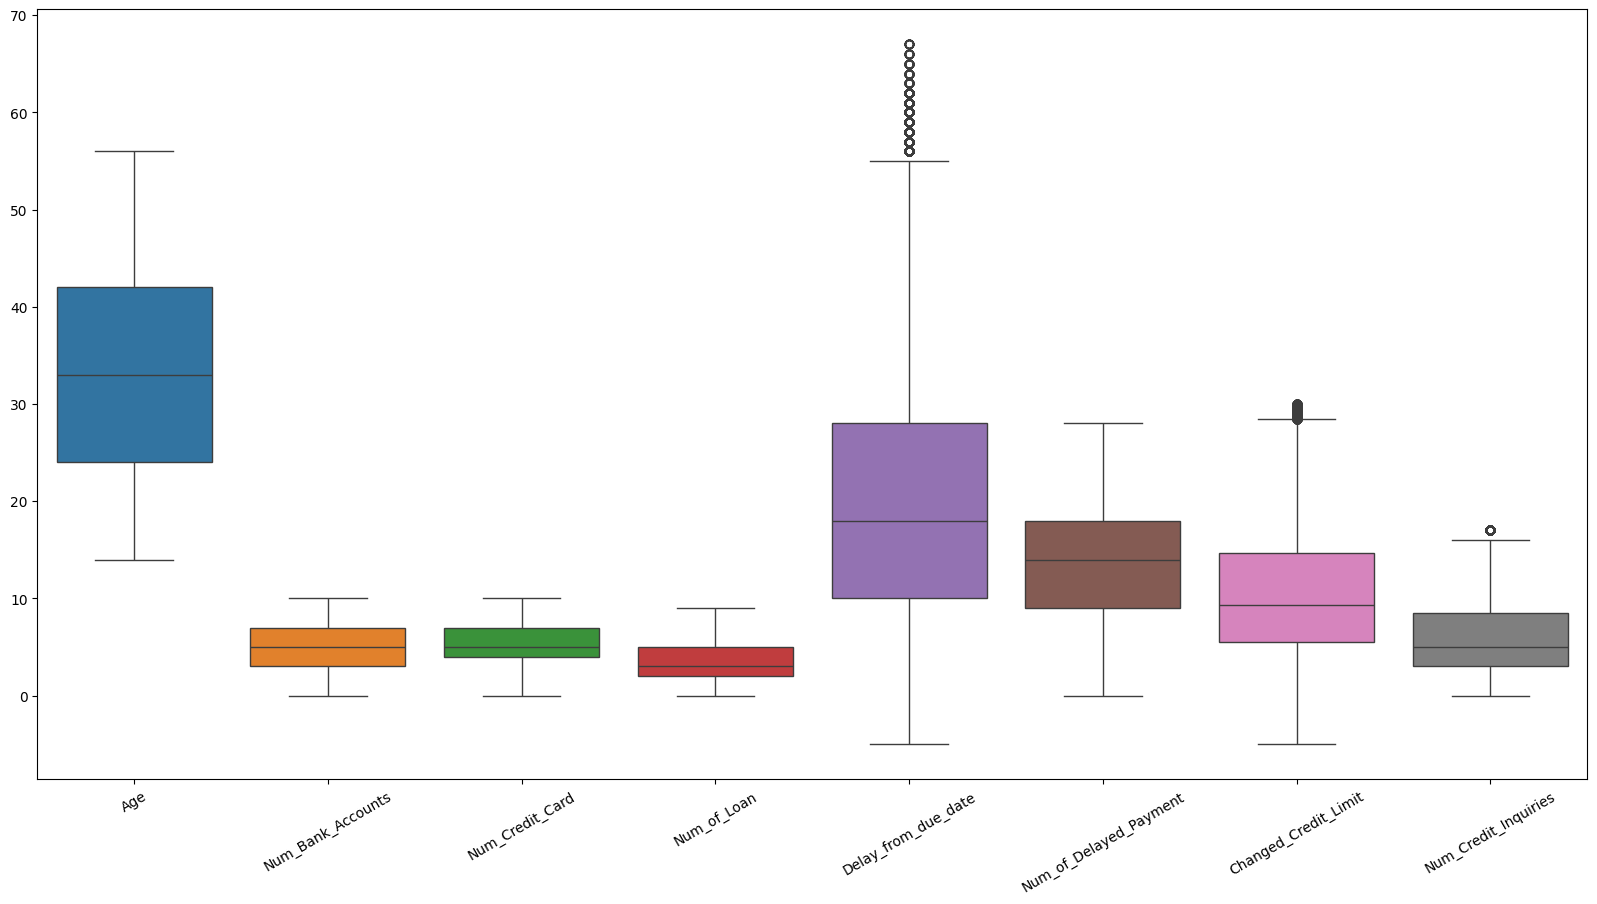

In [74]:
plt.figure(figsize=(20,10))
sns.boxplot(df[group1])
plt.xticks(rotation=30)
plt.show()

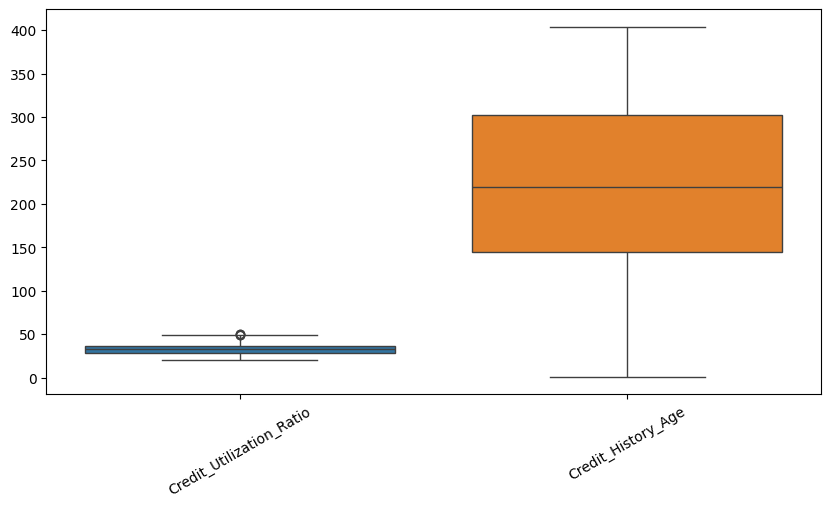

In [75]:
plt.figure(figsize=(10,5))
sns.boxplot(df[group2])
plt.xticks(rotation=30)
plt.show()

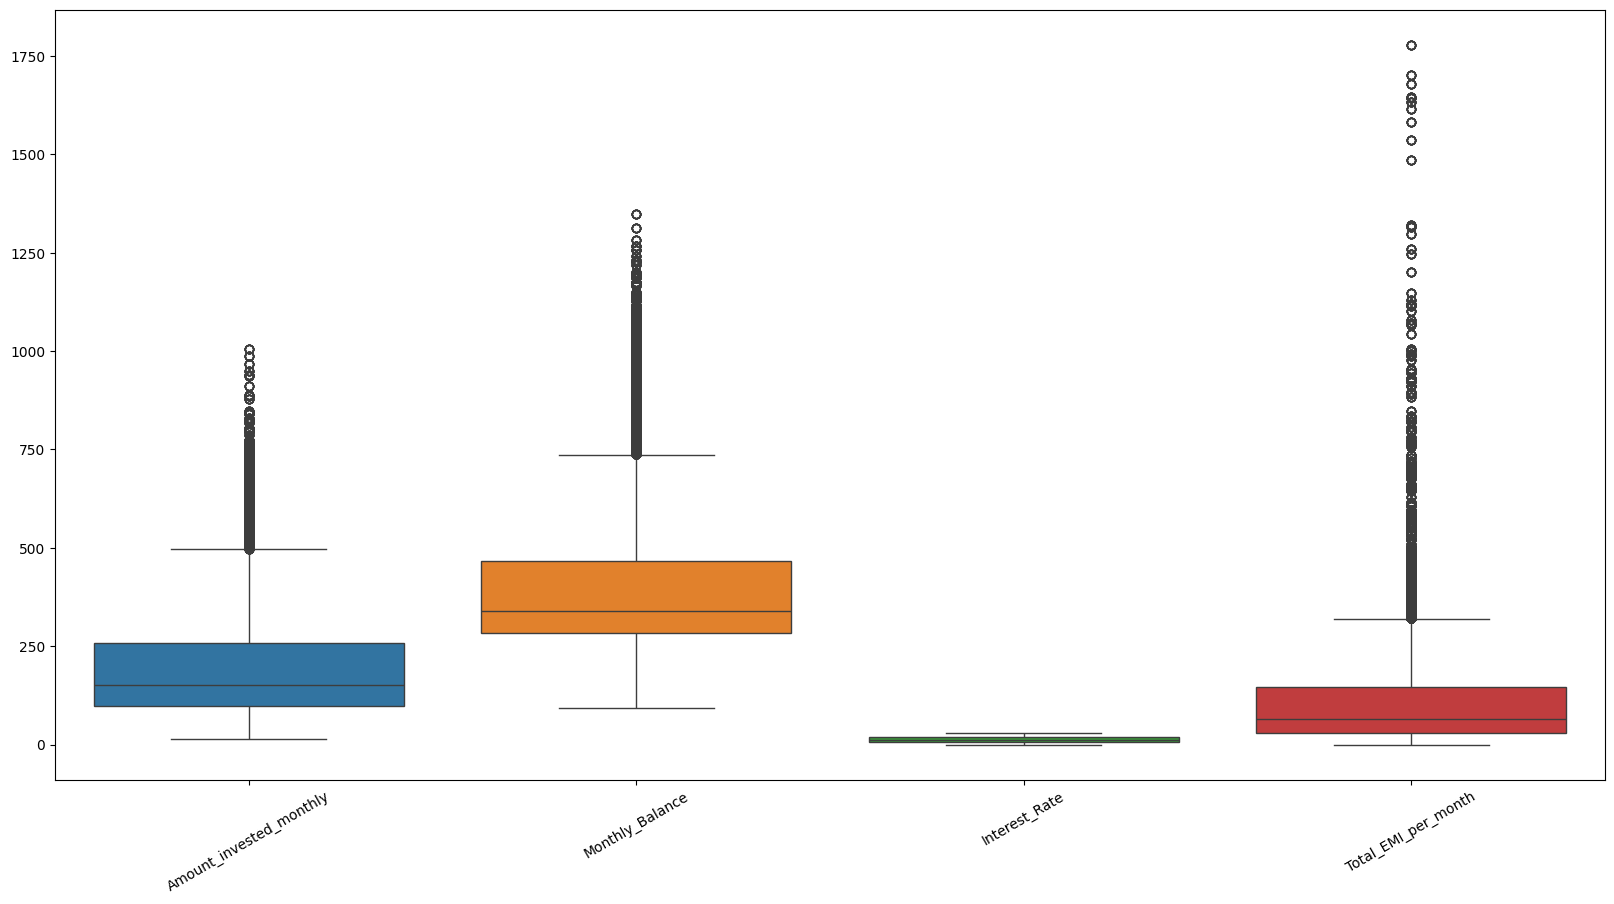

In [76]:
plt.figure(figsize=(20,10))
sns.boxplot(df[group3])
plt.xticks(rotation=30)
plt.show()

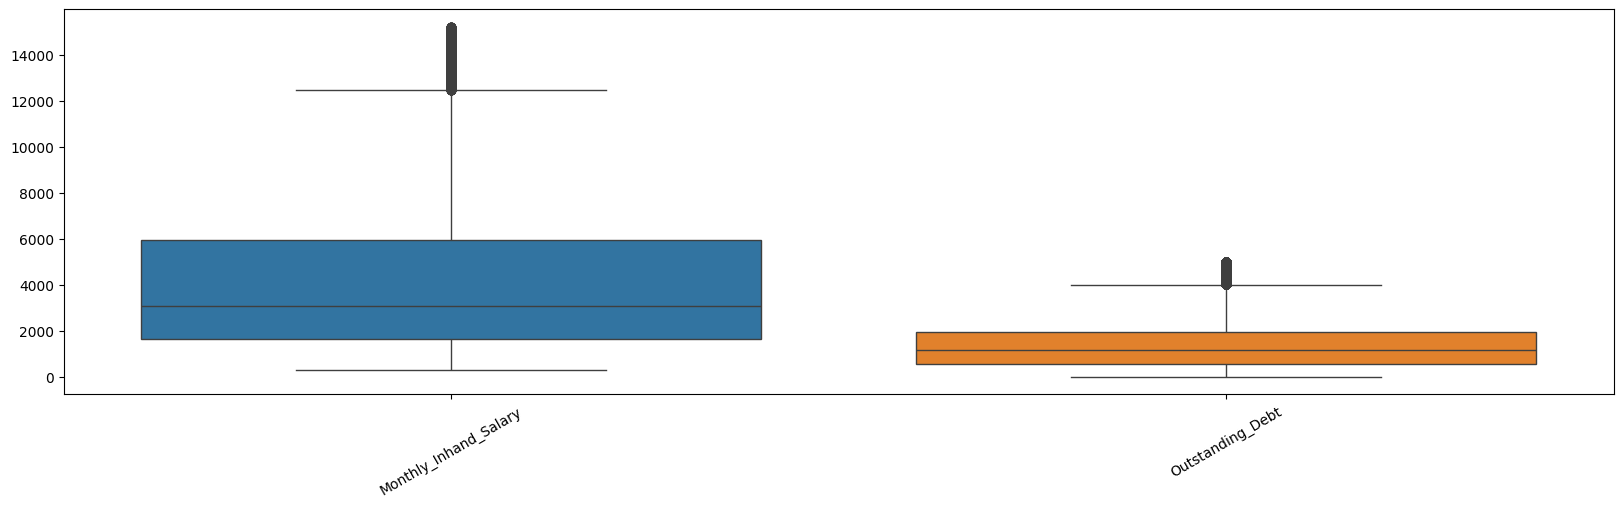

In [77]:
plt.figure(figsize=(20,5))
sns.boxplot(df[group4])
plt.xticks(rotation=30)
plt.show()

In [78]:
def remove_out(df_clean, num_cols, lbv=0.25, hbv=0.75):
    Q1 = df_clean[num_cols].quantile(lbv)
    Q3 = df_clean[num_cols].quantile(hbv)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    higher_bound = Q3 + 1.5*IQR
    for i in num_cols:
        df_clean = df_clean[(df_clean[i]>=lower_bound[i]) & (df_clean[i]<=higher_bound[i])]
    return df_clean

In [79]:
cols = ['Age', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age', 'Amount_invested_monthly', 'Monthly_Balance', 'Interest_Rate', 'Annual_Income']

In [80]:
df = remove_out(df, cols, lbv=0.2, hbv=0.9)
df.shape

(98826, 21)

## 6.Data Preprocessing

In [81]:
cat_df = df.select_dtypes('category')
num_df = df.select_dtypes(exclude='category')

In [82]:
for c in cat_df.columns:
  print(c)
  print(df[c].unique())
  print()

Credit_Mix
['Bad', 'Standard', 'Good']
Categories (3, object): ['Bad', 'Good', 'Standard']

Payment_of_Min_Amount
['No', 'NM', 'Yes']
Categories (3, object): ['NM', 'No', 'Yes']

Payment_Behaviour
['Low_spent_Large_value_payments', 'High_spent_Small_value_payments', 'High_spent_Medium_value_payments', 'Low_spent_Small_value_payments', 'Low_spent_Medium_value_payments', 'High_spent_Large_value_payments']
Categories (6, object): ['High_spent_Large_value_payments', 'High_spent_Medium_value_payments',
                         'High_spent_Small_value_payments', 'Low_spent_Large_value_payments',
                         'Low_spent_Medium_value_payments', 'Low_spent_Small_value_payments']

Credit_Score
['Good', 'Standard', 'Poor']
Categories (3, object): ['Good', 'Poor', 'Standard']



### Encoding

In [83]:
df['Credit_Mix'] = df['Credit_Mix'].map({'Bad': 0, 'Standard': 1, 'Good': 2})
df['Credit_Score'] = df['Credit_Score'].map({'Poor': 0, 'Standard': 1, 'Good': 2})

In [84]:
dummy_df = pd.get_dummies(df[['Payment_Behaviour', 'Payment_of_Min_Amount']], drop_first=True)

df = pd.concat([df, dummy_df], axis=1)
df = df.drop(['Payment_Behaviour', 'Payment_of_Min_Amount'], axis=1)

In [85]:
df['Credit_Mix'] = df['Credit_Mix'].astype('int')
df['Credit_Score'] = df['Credit_Score'].astype('int')

In [86]:
df.shape

(98826, 26)

### Data Spliting

In [87]:
XX = df.drop("Credit_Score", axis=1)
yy = df["Credit_Score"]

In [88]:
sm = SMOTE()
X, y = sm.fit_resample(XX, yy)

In [89]:
X.shape

(157587, 25)

In [90]:
y.value_counts()

,count
Credit_Score,
2,52529
1,52529
0,52529


In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8, random_state=123)

### Scaling

In [92]:
num_columns = list(num_df.columns)

In [93]:
scalar = PowerTransformer(method='yeo-johnson', standardize=True)

In [94]:
X_train[num_columns] = scalar.fit_transform(X_train[num_columns])
X_test[num_columns] = scalar.transform(X_test[num_columns])



## 7.Test Models

In [95]:
a = {'Poor': 0, 'Standard': 1, 'Good': 2}
list(a.keys())

['Poor', 'Standard', 'Good']

In [96]:
def get_best_model(model, params_grid):
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = RandomizedSearchCV(
        estimator = model,
        param_distributions=params_grid,
        scoring='roc_auc',
        cv=folds,
        random_state=42,
        n_jobs=-1)

    grid_search.fit(X_train, y_train)

    return grid_search.best_estimator_

### 7.1 Logistic Regression

In [97]:
logreg_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga']
}

best_logreg = get_best_model(LogisticRegression(), logreg_params)

best_logreg.fit(X_train, y_train)
y_pred = best_logreg.predict(X_test)

accuracy_score(y_test, y_pred)

0.6692366266895108

In [98]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.67      0.69     10506
           1       0.61      0.55      0.58     10506
           2       0.68      0.78      0.73     10506

    accuracy                           0.67     31518
   macro avg       0.67      0.67      0.67     31518
weighted avg       0.67      0.67      0.67     31518



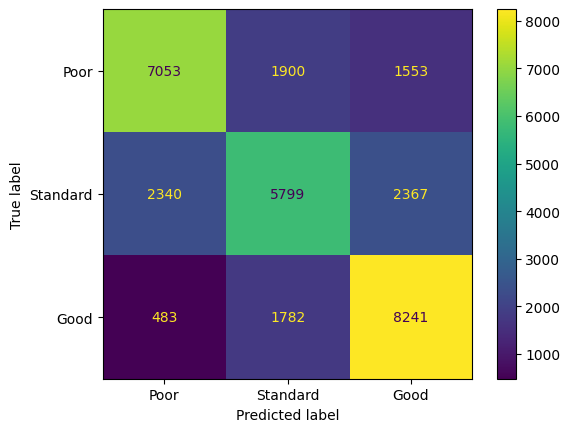

In [99]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(a.keys()))
disp.plot()

### 7.2 RandomForestClassifier


In [117]:
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 50, 100],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
best_rf = get_best_model(RandomForestClassifier(), rf_params)

best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)

accuracy_score(y_test, y_pred)

0.863506567675614

In [118]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.90      0.88     10506
           1       0.85      0.76      0.80     10506
           2       0.87      0.94      0.90     10506

    accuracy                           0.86     31518
   macro avg       0.86      0.86      0.86     31518
weighted avg       0.86      0.86      0.86     31518



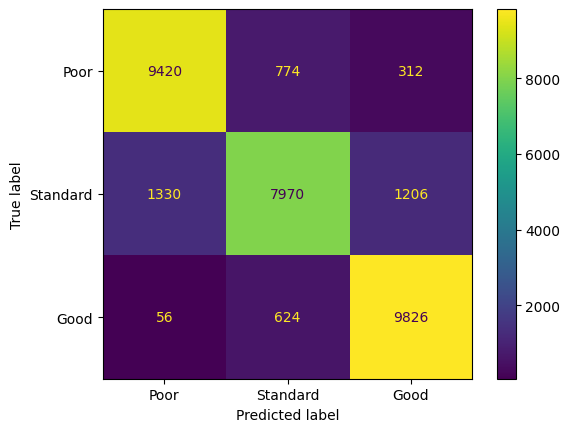

In [119]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(a.keys()))
disp.plot()

### 7.3 XGBClassifier

In [100]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [101]:
xgb_params = {
    'max_depth': [5, 8],
    'n_estimators': [200, 250, 300],
    'learning_rate': [0.001, 0.1],
}

In [102]:
estimator = XGBClassifier(learning_rate=0.1,
                          min_child_weight=1,
                          gamma=0,
                          subsample=0.9,
                          class_weight='balanced',
                          random_state=42,
                          n_jobs=-1,
                          tree_method='gpu_hist')

best_xgb = get_best_model(estimator, xgb_params)

In [103]:
best_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weight='balanced', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=250,
              n_jobs=-1, num_parallel_tree=None, ...)

In [104]:
y_pred= best_xgb.predict(X_test)
accuracy_score(y_test, y_pred)

0.861000063455803

We can see that Random Forest has better accuracy

In [105]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.90      0.88     10506
           1       0.83      0.76      0.80     10506
           2       0.88      0.92      0.90     10506

    accuracy                           0.86     31518
   macro avg       0.86      0.86      0.86     31518
weighted avg       0.86      0.86      0.86     31518



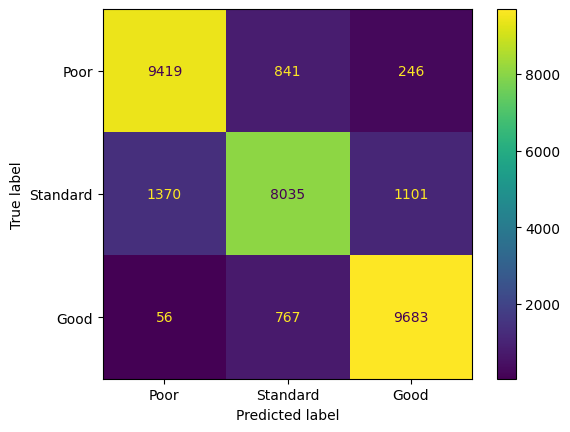

In [107]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(a.keys()))
disp.plot()

Let`s plot feture importances

In [109]:
def plot_feature_importances(feature_importances, cols):
    features = pd.DataFrame(feature_importances, columns=['coef_value']).set_index(cols)
    features = features.sort_values(by='coef_value', ascending=False)
    top_features = features
    plt.figure(figsize=(10, 6))
    sns.barplot(x='coef_value', y=features.index, data=features)
    plt.show()
    return top_features

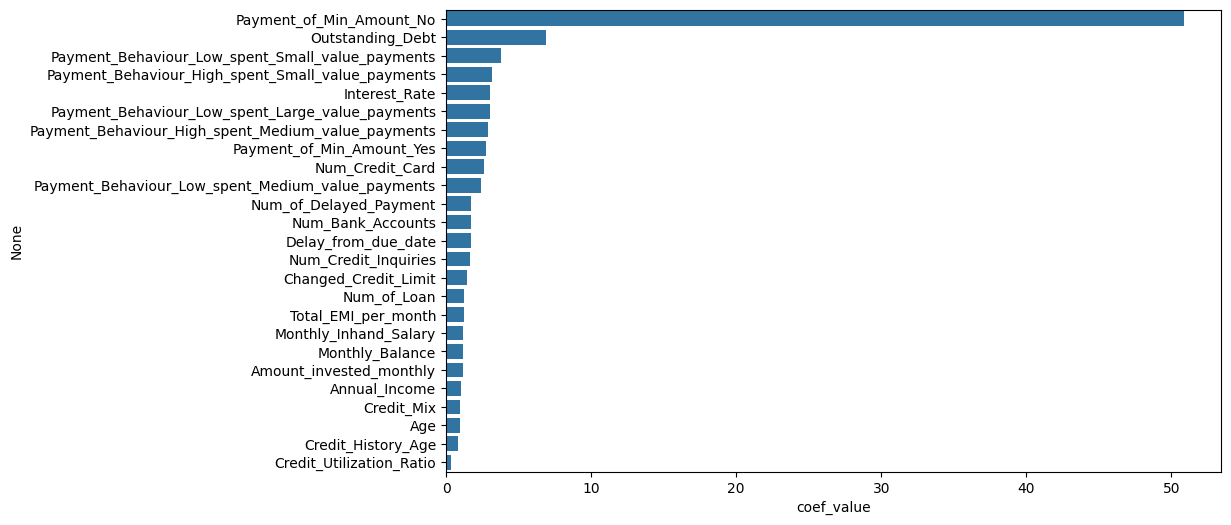

In [111]:
top_featues = plot_feature_importances(best_xgb.feature_importances_*100, X_train.columns)